#Getting the Data

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ranaatul61","key":"***"}'}

In [2]:
!pip install kaggle

In [3]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 66 Apr  5 04:37 kaggle.json


In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c msk-redefining-cancer-treatment

  0% 0.00/24.2k [00:00<?, ?B/s]
100% 24.2k/24.2k [00:00<00:00, 10.2MB/s]
  0% 0.00/47.5k [00:00<?, ?B/s]
100% 47.5k/47.5k [00:00<00:00, 41.4MB/s]
 67% 41.0M/61.0M [00:00<00:00, 46.9MB/s]
100% 61.0M/61.0M [00:00<00:00, 96.0MB/s]
 96% 95.0M/99.0M [00:01<00:00, 67.6MB/s]
100% 99.0M/99.0M [00:01<00:00, 89.9MB/s]
  0% 0.00/765 [00:00<?, ?B/s]
100% 765/765 [00:00<00:00, 708kB/s]
  0% 0.00/7.25k [00:00<?, ?B/s]
100% 7.25k/7.25k [00:00<00:00, 7.65MB/s]
100% 8.88M/8.88M [00:00<00:00, 31.8MB/s]

  0% 0.00/1.28k [00:00<?, ?B/s]
100% 1.28k/1.28k [00:00<00:00, 1.10MB/s]
  0% 0.00/592 [00:00<?, ?B/s]
100% 592/592 [00:00<00:00, 475kB/s]


In [6]:
!unzip training_variants.zip
!unzip training_text.zip
!unzip test_variants.zip
!unzip test_text.zip
!ls

Archive:  training_variants.zip
  inflating: training_variants       
Archive:  training_text.zip
  inflating: training_text           
Archive:  test_variants.zip
  inflating: test_variants           
Archive:  test_text.zip
  inflating: test_text               
kaggle.json			 test_text.zip
sample_data			 test_variants
stage1_solution_filtered.csv.7z  test_variants.zip
stage_2_private_solution.csv.7z  training_text
stage2_sample_submission.csv.7z  training_text.zip
stage2_test_text.csv.7z		 training_variants
stage2_test_variants.csv.7z	 training_variants.zip
test_text


#Importing the Libaries

In [0]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import normalize
from scipy.sparse import hstack

from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


In [0]:
data = pd.read_csv('training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


In [0]:
# note the seprator in this file
data_text =pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


ID                                               TEXT
0   0  Cyclin-dependent kinases (CDKs) regulate a var...
1   1   Abstract Background  Non-small cell lung canc...
2   2   Abstract Background  Non-small cell lung canc...
3   3  Recent evidence has demonstrated that acquired...
4   4  Oncogenic mutations in the monomeric Casitas B...

In [0]:
print(data_text['TEXT'][1])

 Abstract Background  Non-small cell lung cancer (NSCLC) is a heterogeneous group of disorders with a number of genetic and proteomic alterations. c-CBL is an E3 ubiquitin ligase and adaptor molecule important in normal homeostasis and cancer. We determined the genetic variations of c-CBL, relationship to receptor tyrosine kinases (EGFR and MET), and functionality in NSCLC.  Methods and Findings  Using archival formalin-fixed paraffin embedded (FFPE) extracted genomic DNA, we show that c-CBL mutations occur in somatic fashion for lung cancers. c-CBL mutations were not mutually exclusive of MET or EGFR mutations; however they were independent of p53 and KRAS mutations. In normal/tumor pairwise analysis, there was significant loss of heterozygosity (LOH) for the c-CBL locus (22%, n = 8/37) and none of these samples revealed any mutation in the remaining copy of c-CBL. The c-CBL LOH also positively correlated with EGFR and MET mutations observed in the same samples. Using select c-CBL som

# Unlabeled Data

In [8]:
test_data = pd.read_csv('test_variants')
test_data.head(10)

ID     Gene Variation
0   0    ACSL4     R570S
1   1    NAGLU     P521L
2   2      PAH     L333F
3   3     ING1     A148D
4   4  TMEM216      G77A
5   5   CD40LG     A123E
6   6    KLF11     T220M
7   7     SGCB     T151R
8   8    CLCF1     R197L
9   9   SDHAF1      R55P

In [9]:
test_text = pd.read_csv("test_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
test_text.head(10)

ID                                               TEXT
0   0  2. This mutation resulted in a myeloproliferat...
1   1   Abstract The Large Tumor Suppressor 1 (LATS1)...
2   2  Vascular endothelial growth factor receptor (V...
3   3  Inflammatory myofibroblastic tumor (IMT) is a ...
4   4   Abstract Retinoblastoma is a pediatric retina...
5   5  The accurate determination of perfluoroalkyl s...
6   6  Aberrations in the mTOR (mechanistic target of...
7   7  Oncogenic mutations in the monomeric Casitas B...
8   8  NPM1 gene at chromosome 5q35 is involved in re...
9   9  Introduction The epidermal growth factor recep...

##Preprocessing

In [10]:
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
      
        total_text = re.sub("[^a-zA-Z0-9-*_\n]"," ", str(total_text))
        total_text = re.sub("\s+"," ", total_text)
        total_text = total_text.lower()
        
        
        string = ' '.join([w for w in total_text.split() if w not in stop_words])
        #removing special character, multiple space and stopwords from text
        data_text[column][index] = string

for index, row in data_text.iterrows():
    nlp_preprocessing(row['TEXT'], index, 'TEXT')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Test Unlabeled Data

In [12]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
      
        total_text = re.sub("[^a-zA-Z0-9-*_\n]"," ", str(total_text))
        total_text = re.sub("\s+"," ", total_text)
        total_text = total_text.lower()
        
        
        string = ' '.join([w for w in total_text.split() if w not in stop_words])
        #removing special character, multiple space and stopwords from text
        test_text[column][index] = string

for index, row in test_text.iterrows():
    nlp_preprocessing(row['TEXT'], index, 'TEXT')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [13]:
test_text.head(10)

ID                                               TEXT
0   0  2 mutation resulted myeloproliferative phenoty...
1   1  abstract large tumor suppressor 1 lats1 serine...
2   2  vascular endothelial growth factor receptor ve...
3   3  inflammatory myofibroblastic tumor imt neoplas...
4   4  abstract retinoblastoma pediatric retinal tumo...
5   5  accurate determination perfluoroalkyl substanc...
6   6  aberrations mtor mechanistic target rapamycin ...
7   7  oncogenic mutations monomeric casitas b-lineag...
8   8  npm1 gene chromosome 5q35 involved recurrent t...
9   9  introduction epidermal growth factor receptor ...

In [14]:
test_text.shape

(5668, 2)

In [0]:
unlabel = pd.merge(test_data, test_text,on='ID', how='left')

In [16]:
unlabel.head()

ID     Gene Variation                                               TEXT
0   0    ACSL4     R570S  2 mutation resulted myeloproliferative phenoty...
1   1    NAGLU     P521L  abstract large tumor suppressor 1 lats1 serine...
2   2      PAH     L333F  vascular endothelial growth factor receptor ve...
3   3     ING1     A148D  inflammatory myofibroblastic tumor imt neoplas...
4   4  TMEM216      G77A  abstract retinoblastoma pediatric retinal tumo...

##Preparing the Data

In [0]:
result = pd.merge(data, data_text,on='ID', how='left')

In [0]:
result[ result['Class']==1 ].head()

ID    Gene             Variation  Class  \
0    0  FAM58A  Truncating Mutations      1   
7    7     CBL              Deletion      1   
16  16     CBL  Truncating Mutations      1   
37  37  DICER1                D1709E      1   
38  38  DICER1                D1709A      1   

                                                 TEXT  
0   cyclin-dependent kinases cdks regulate variety...  
7   cbl negative regulator activated receptor tyro...  
16  determine residual cylindrical refractive erro...  
37  sex cord stromal tumors germ-cell tumors accou...  
38  sex cord stromal tumors germ-cell tumors accou...

In [0]:
print(result['TEXT'][0])

cyclin-dependent kinases cdks regulate variety fundamental cellular processes cdk10 stands one last orphan cdks activating cyclin identified kinase activity revealed previous work shown cdk10 silencing increases ets2 v-ets erythroblastosis virus e26 oncogene homolog 2 -driven activation mapk pathway confers tamoxifen resistance breast cancer cells precise mechanisms cdk10 modulates ets2 activity generally functions cdk10 remain elusive demonstrate cdk10 cyclin-dependent kinase identifying cyclin activating cyclin cyclin orphan cyclin product fam58a whose mutations cause star syndrome human developmental anomaly whose features include toe syndactyly telecanthus anogenital renal malformations show star syndrome-associated cyclin mutants unable interact cdk10 cyclin silencing phenocopies cdk10 silencing increasing c-raf conferring tamoxifen resistance breast cancer cells cdk10 cyclin phosphorylates ets2 vitro cells positively controls ets2 degradation proteasome ets2 protein levels increa

In [0]:
result[ result['Class']==2 ].head()

ID   Gene      Variation  Class  \
1    1    CBL          W802*      2   
2    2    CBL          Q249E      2   
33  33   TERT  Amplification      2   
71  71  CCND2  Amplification      2   
75  75  CCND3  Amplification      2   

                                                 TEXT  
1   abstract background non-small cell lung cancer...  
2   abstract background non-small cell lung cancer...  
33  current world health organization classificati...  
71  cyclin-dependent protein kinases cdks regulate...  
75  cyclin-dependent protein kinases cdks regulate...

In [0]:
print(result['TEXT'][1])

abstract background non-small cell lung cancer nsclc heterogeneous group disorders number genetic proteomic alterations c-cbl e3 ubiquitin ligase adaptor molecule important normal homeostasis cancer determined genetic variations c-cbl relationship receptor tyrosine kinases egfr met functionality nsclc methods findings using archival formalin-fixed paraffin embedded ffpe extracted genomic dna show c-cbl mutations occur somatic fashion lung cancers c-cbl mutations mutually exclusive met egfr mutations however independent p53 kras mutations normal tumor pairwise analysis significant loss heterozygosity loh c-cbl locus 22 n 8 37 none samples revealed mutation remaining copy c-cbl c-cbl loh also positively correlated egfr met mutations observed samples using select c-cbl somatic mutations s80n h94y q249e w802* obtained caucasian taiwanese african-american samples respectively transfected nsclc cell lines increased cell viability cell motility conclusions taking overall mutation rate c-cbl c

In [0]:
result[ result['Class']==3 ].head()

ID     Gene Variation  Class  \
3      3      CBL     N454D      3   
196  196     EGFR     C628Y      3   
295  295    CHEK2      P85L      3   
303  303  TMPRSS2      T75M      3   
305  305  TMPRSS2     M160V      3   

                                                  TEXT  
3    recent evidence demonstrated acquired uniparen...  
196  feature many gliomas amplification epidermal g...  
295  checkpoint kinase 2 chek2 chk2 emerges importa...  
303  serine protease tmprss2 gene expression studie...  
305  serine protease tmprss2 gene expression studie...

In [0]:
print(result['TEXT'][3])

recent evidence demonstrated acquired uniparental disomy aupd novel mechanism pathogenetic mutations cancer may reduced homozygosity help identify novel mutations myeloproliferative neoplasms mpns performed genome-wide single nucleotide polymorphism snp screen identify aupd 58 patients atypical chronic myeloid leukemia acml n 30 jak2 mutation negative myelofibrosis mf n 18 jak2 mutation negative polycythemia vera pv n 10 stretches homozygous copy neutral snp calls greater 20mb seen 10 33 acml 1 6 mf absent pv total 7 different chromosomes involved 7q 11q affected 10 acml cases cbl mutations identified 3 cases 11q aupd analysis 574 additional mpns revealed total 27 cbl variants 26 patients acml myelofibrosis chronic myelomonocytic leukemia variants missense substitutions ring linker domains abrogated cbl ubiquitin ligase activity conferred proliferative advantage 32d cells overexpressing flt3 conclude acquired transforming cbl mutations novel widespread pathogenetic abnormality morpholo

In [0]:
result[ result['Class']==4 ].head()

ID Gene Variation  Class  \
4    4  CBL     L399V      4   
5    5  CBL     V391I      4   
8    8  CBL     Y371H      4   
9    9  CBL     C384R      4   
10  10  CBL     P395A      4   

                                                 TEXT  
4   oncogenic mutations monomeric casitas b-lineag...  
5   oncogenic mutations monomeric casitas b-lineag...  
8   abstract juvenile myelomonocytic leukemia jmml...  
9   abstract juvenile myelomonocytic leukemia jmml...  
10  oncogenic mutations monomeric casitas b-lineag...

In [0]:
print(result['TEXT'][4])

oncogenic mutations monomeric casitas b-lineage lymphoma cbl gene found many tumors significance remains largely unknown several human c-cbl cbl structures recently solved depicting protein different stages activation cycle thus provide mechanistic insight underlying stability-activity tradeoffs cancer-related proteins may influence disease onset progression study computationally modeled effects missense cancer mutations structures representing four stages cbl activation cycle identify driver mutations affect cbl stability binding activity found recurrent homozygous leukemia-specific mutations greater destabilizing effects cbl states random non-cancer mutations tested ability computational models assessing changes cbl stability binding ubiquitin conjugating enzyme e2 performing blind cbl-mediated egfr ubiquitination assays cells experimental cbl ubiquitin ligase activity agreement predicted changes cbl stability lesser extent cbl-e2 binding affinity two-thirds experimentally tested mut

In [0]:
result[ result['Class']==5 ].head()

ID  Gene Variation  Class  \
6      6   CBL     V430M      5   
14    14   CBL     P428L      5   
18    18   CBL     M374V      5   
106  106  MSH6      G39E      5   
109  109  MSH6    R1095H      5   

                                                  TEXT  
6    oncogenic mutations monomeric casitas b-lineag...  
14   oncogenic mutations monomeric casitas b-lineag...  
18   oncogenic mutations monomeric casitas b-lineag...  
106  identification high-risk disease-causing const...  
109  mismatch repair mmr malfunction causes accumul...

In [0]:
print(result['TEXT'][106])

identification high-risk disease-causing constitutional mutation cancer patient guides clinical management whole family implications counseling cancer treatment options presymptomatic surveillance considerations risk-reducing surgery medication regimens1 carriers mutations mismatch repair mmr genes mlh1 msh2 msh6 pms2 causing lynch syndrome1 substantially increased risk colorectal endometrial cancers along increased risk ovarian gastric small bowel urothelial brain hepatobiliary pancreatic bladder kidney prostate breast cancers1 2 3 4 5 6 7 8 however intensive management reduces mortality9 sequence variants uncertain functional clinical relevance common genetic test reports although several lines evidence evaluated assess clinical implications variants usually none approaches used obtain clinically useful interpretations many variants comprehensive data lacking laboratories generally conservative designating pathogenic variants defining variants uncertain significance unless overwhelmi

In [0]:
result[ result['Class']==6 ].head()

ID   Gene Variation  Class  \
20    20    CBL      H94Y      6   
191  191   EGFR     S921R      6   
293  293  CHEK2     I157T      6   
328  328   ROS1    L1951R      6   
383  383   TP53     H115N      6   

                                                  TEXT  
20   abstract background non-small cell lung cancer...  
191  assess role various epidermal growth factor re...  
293  recently functionally defective chek2 variant ...  
328  increasing number genetic alterations aberrant...  
383  sequence-specific dna binding exonuclease acti...

In [0]:
print(result['TEXT'][191])

assess role various epidermal growth factor receptor egfr mutations her2 3 protein expression predictive markers responsiveness gewtinib therapy chinese patients advanced nonsmall cell lung cancer nsclc methods total 106 chinese nsclc patients failed least one chemotherapy regimen received gewtinib 250 mg daily 106 tumors patients screened mutations egfr exons 18 24 84 tumors studied immunohistochemistry her2 3 expression correlated clinical treatment outcome results patients egfr mutations signiwcantly higher overall response rate orr longer time progression ttp overall survival os compared wild-type receptor diverence orr observed patients exon 19 deletion patients egfr mutations orr her2-positive patients signiwcantly higher her2-negative group irrespective egfr mutational status trend better orr observed her3-positive patients her2 her3 expression levels associated diverence terms ttp os nevertheless considering subgroups non-responders gewtinib median ttp patients mutated egfr sig

In [0]:
result[ result['Class']==7 ].head()

ID  Gene           Variation  Class  \
28  28  TERT               C228T      7   
31  31  TERT  Promoter Mutations      7   
34  34  TERT               C250T      7   
67  67  RHEB                Y35C      7   
68  68  RHEB                Y35N      7   

                                                 TEXT  
28  sequencing studies identified many recurrent c...  
31  sequencing studies identified many recurrent c...  
34  sequencing studies identified many recurrent c...  
67  genes encoding components pi3k-akt-mtor signal...  
68  genes encoding components pi3k-akt-mtor signal...

In [0]:
print(result['TEXT'][28])

sequencing studies identified many recurrent coding mutations human cancer genes however highly recurrent mutations involving regulatory regions rarely observed describe two independent mutations within tert core promoter taken together observed 71 50 70 melanomas generate de novo consensus ets binding motifs reporter assays showed mutations increase transcriptional activity tert promoter 2 4-fold examination cancer cell lines derived diverse tumor types revealed mutations 16 24 150 cases preliminary evidence elevated frequency bladder hepatocellular cancer cells thus somatic mutations regulatory regions genome may represent important tumorigenic mechanism systematic characterization human cancer genomes led discovery wide range mutated genes contribute tumor development progression somatic mutations tumors reside within protein-coding regions genes splice junctions determine whether tumor genomes harbor recurrent mutations outside protein-coding regions systematically queried noncodin

In [0]:
result[ result['Class']==8 ].head()

ID   Gene Variation  Class  \
121  121  SF3B1     K700R      8   
220  220   EGFR     S492R      8   
306  306  H3F3A      G35R      8   
307  307  H3F3A      K28M      8   
308  308  H3F3A      G35V      8   

                                                  TEXT  
121  rna maturation important complex biological pr...  
220  antibodies epidermal growth factor receptor eg...  
306  dna entry exit points nucleosome core regulate...  
307  dna entry exit points nucleosome core regulate...  
308  dna entry exit points nucleosome core regulate...

In [0]:
print(result['TEXT'][220])

antibodies epidermal growth factor receptor egfr cetuximab panitumumab widely used treat colorectal cancer unfortunately patients eventually develop resistance agents describe acquired egfr ectodomain mutation s492r prevents cetuximab binding confers resistance cetuximab cells mutation however retain binding growth inhibited panitumumab two ten subjects studied disease progression cetuximab treatment acquired mutation subject cetuximab resistance harboring s492r mutation responded treatment panitumumab subject terms cancer therapeutic resistance colorectal cancer tumour biomarkers glance figures first 1-2 2 last view figures left cetuximab-resistant cells sensitive egfr tyrosine kinase inhibitor gefitinib monoclonal antibody egfr panitumumab figure 1 cetuximab-resistant cells harbor missense mutation s492r within extracellular domain egfr figure 2 right main main change history references acknowledgments author information supplementary information development antibodies egfr cetuximab

In [0]:
result[ result['Class']==9 ].head()

ID   Gene Variation  Class  \
122  122  SF3B1     R625C      9   
123  123  SF3B1     E622D      9   
124  124  SF3B1     H662Q      9   
125  125  SF3B1     R625D      9   
126  126  SF3B1     K666M      9   

                                                  TEXT  
122  rna maturation important complex biological pr...  
123  splicing factor sf3b1 commonly mutated gene my...  
124  splicing factor sf3b1 commonly mutated gene my...  
125  rna maturation important complex biological pr...  
126  rna maturation important complex biological pr...

In [0]:
print(result['TEXT'][123])

splicing factor sf3b1 commonly mutated gene myelodysplastic syndrome mds particularly patients refractory anemia ring sideroblasts rars investigated functional effects sf3b1 disruption myeloid cell lines sf3b1 knockdown resulted growth inhibition cell cycle arrest impaired erythroid differentiation deregulation many genes pathways including cell cycle regulation rna processing mds disorder hematopoietic stem cell thus studied transcriptome cd34 cells mds patients sf3b1 mutations using rna sequencing genes significantly differentially expressed transcript exon level sf3b1 mutant compared wild-type cases include genes involved mds pathogenesis asxl1 cbl iron homeostasis mitochondrial metabolism alas2 abcb7 slc25a37 rna splicing processing prpf8 hnrnpd many genes regulated dna damage-induced brca1 bclaf1 sf3b1 protein complex showed differential expression splicing sf3b1 mutant cases first study determine target genes sf3b1 mutation mds cd34 cells data indicate sf3b1 critical role mds aff

##Operational Data

In [0]:
result.head()

ID    Gene             Variation  Class  \
0   0  FAM58A  Truncating Mutations      1   
1   1     CBL                 W802*      2   
2   2     CBL                 Q249E      2   
3   3     CBL                 N454D      3   
4   4     CBL                 L399V      4   

                                                TEXT  
0  cyclin-dependent kinases cdks regulate variety...  
1  abstract background non-small cell lung cancer...  
2  abstract background non-small cell lung cancer...  
3  recent evidence demonstrated acquired uniparen...  
4  oncogenic mutations monomeric casitas b-lineag...

In [0]:
result.to_csv("DataSet.csv", index=False)

In [0]:
!ls -l --block-size=MiB

total 528MiB
-rw-r--r-- 1 root root 157MiB Mar 15 04:27 DataSet.csv
-rw-r--r-- 1 root root   1MiB Mar 15 04:19 kaggle.json
drwxr-xr-x 1 root root   1MiB Mar  8 17:26 sample_data
-rw-r--r-- 1 root root   1MiB Mar 15 04:20 stage1_solution_filtered.csv.7z
-rw-r--r-- 1 root root   1MiB Mar 15 04:20 stage_2_private_solution.csv.7z
-rw-r--r-- 1 root root   1MiB Mar 15 04:20 stage2_sample_submission.csv.7z
-rw-r--r-- 1 root root   9MiB Mar 15 04:20 stage2_test_text.csv.7z
-rw-r--r-- 1 root root   1MiB Mar 15 04:20 stage2_test_variants.csv.7z
-rw-r--r-- 1 root root  99MiB Mar 15 04:20 test_text.zip
-rw-r--r-- 1 root root   1MiB Mar 15 04:20 test_variants.zip
-rw-r--r-- 1 root root 203MiB Jun 20  2018 training_text
-rw-r--r-- 1 root root  61MiB Mar 15 04:20 training_text.zip
-rw-rw-r-- 1 root root   1MiB Jun 22  2017 training_variants
-rw-r--r-- 1 root root   1MiB Mar 15 04:20 training_variants.zip


## Uploading and  Files

In [17]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
unlabel.to_csv('/content/gdrive/My Drive/DataSet_unlabel.csv', index=False)

#Train Test Split

In [0]:
X, x_test,Y, y_test = train_test_split(result, result['Class'], stratify=result['Class'], test_size=0.2)

In [0]:
X.head()

ID   Gene   Variation  Class  \
856    856   ABL1       V379I      2   
3274  3274    RET       S765P      4   
114    114   MSH6  F1088Sfs*2      4   
2764  2764   BRAF       E275K      2   
2354  2354  STK11        L67P      4   

                                                   TEXT  
856   abstract mutations bcr-abl kinase domain may c...  
3274  many missense mutations ret proto-oncogene fou...  
114   establishedmsh6-null mice present afrequent oc...  
2764  noonan leopard cardiofaciocutaneous syndromes ...  
2354  peutz-jeghers syndrome pjs autosomal dominant ...

In [0]:
Y.head()

856     2
3274    4
114     4
2764    2
2354    4
Name: Class, dtype: int64

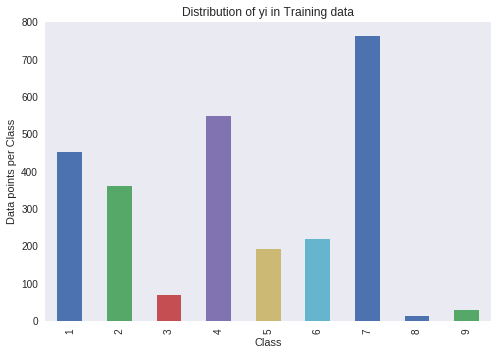

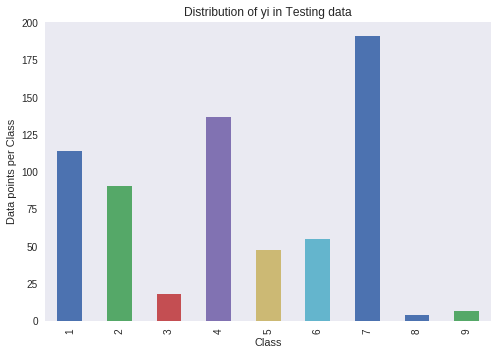

In [0]:
train_class_dist= X['Class'].value_counts().sort_index()
test_class_dist = x_test['Class'].value_counts().sort_index()


def print_distribution( VAL, name):
  VAL.plot(kind='bar')
  plt.xlabel('Class')
  plt.ylabel('Data points per Class')
  plt.title('Distribution of yi in '+name+' data')
  plt.grid()
  plt.show()
  
print_distribution( train_class_dist, 'Training' )
print_distribution( test_class_dist, 'Testing' )

#One Hot Encoding of Gene and Variations

In [0]:
G_V = CountVectorizer()
train_gene = G_V.fit_transform(X['Gene'])
test_gene  = G_V.transform(x_test['Gene'])

In [0]:
print( train_gene.shape, test_gene.shape)

(2656, 251) (665, 251)


In [0]:
V_V = CountVectorizer()
train_variation = V_V.fit_transform(X['Variation'])
test_variation = V_V.transform(x_test['Variation'])

In [0]:
print( train_variation.shape, test_variation.shape)

(2656, 2438) (665, 2438)


In [0]:
train_gene_var_onehotCoding = hstack((train_gene,train_variation))
test_gene_var_onehotCoding = hstack((test_gene,test_variation))


train_y = np.array(list(X['Class']))
test_y = np.array(list(x_test['Class']))


In [0]:
print( train_gene_var_onehotCoding.shape, test_gene_var_onehotCoding.shape)

(2656, 2689) (665, 2689)


#BOW of Text

In [0]:
T_V = CountVectorizer()
train_text_onehotCoding = T_V.fit_transform(X['TEXT'])
train_text_onehotCoding = normalize(train_text_onehotCoding, axis=0)

test_text_onehotCoding = T_V.transform(x_test['TEXT'])
test_text_onehotCoding = normalize(test_text_onehotCoding, axis=0)

In [0]:
print(train_text_onehotCoding.shape, test_text_onehotCoding.shape)

(2656, 139547) (665, 139547)


##BOW Stacking with gene and variation

In [0]:
train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_onehotCoding)).tocsr()
test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_onehotCoding)).tocsr()

In [0]:
print(train_x_onehotCoding.shape, test_x_onehotCoding.shape)

(2656, 142236) (665, 142236)


#Term Frequency and Invers Document Frequency

In [0]:
encoding = TfidfVectorizer()
train_text_tfidf = encoding.fit_transform(X['TEXT'])
train_text_tfidf = normalize(train_text_tfidf, axis=0)

test_text_tfidf = encoding.transform(x_test['TEXT'])
test_text_tfidf = normalize(test_text_tfidf, axis=0)

print(train_text_tfidf.shape, test_text_tfidf.shape)

(2656, 139547) (665, 139547)


##TFIDF Stacking with gene and variation

In [0]:
train_x_tfidf = hstack((train_gene_var_onehotCoding, train_text_tfidf)).tocsr()
test_x_tfidf = hstack((test_gene_var_onehotCoding, test_text_tfidf)).tocsr()

print(train_x_tfidf.shape, test_x_tfidf.shape)

(2656, 141626) (665, 141626)


#Classifiers

In [0]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we will provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    print("Actual :", test_y[0])
    print("Probability :",np.round(sig_clf.predict_proba(test_x[0]),4))
    print("Predicted :", sig_clf.predict(test_x[0]))
    # calculating the number of data points that are misclassified
    # print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0], 1-np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    print(confusion_matrix(test_y, pred_y))
    print("Score :",sig_clf.score(test_x, test_y))

#TFIDF Testing

## TFIDF with LR



In [0]:
clf = SGDClassifier(class_weight='balanced', alpha=0.001, penalty='l2', loss='log', random_state=32 ,max_iter=1000, tol=0.0001)
predict_and_plot_confusion_matrix(train_x_tfidf, train_y, test_x_tfidf, test_y, clf)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Log loss : 1.0739727856255024
Actual : 7
Probability : [[0.0126 0.5813 0.0006 0.0121 0.004  0.0007 0.3757 0.0111 0.0019]]
Predicted : [2]
[[ 74   1   0  20   8   2   9   0   0]
 [  3  43   0   2   1   1  41   0   0]
 [  1   0   5   4   0   0   8   0   0]
 [ 10   2   1  98  11   1  14   0   0]
 [  9   0   0   8  17   5   9   0   0]
 [  9   1   1   2   2  33   7   0   0]
 [  1   9   4   0   3   0 174   0   0]
 [  0   1   0   0   0   0   3   0   0]
 [  1   0   0   0   0   0   2   1   3]]
Score : 0.6721804511278195


##TFIDF with NB

###Multinomial

In [0]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
predict_and_plot_confusion_matrix(train_x_tfidf, train_y, test_x_tfidf, test_y, clf)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Log loss : 1.2311773577246499
Actual : 5
Probability : [[0.093  0.077  0.024  0.075  0.047  0.0358 0.6406 0.0044 0.0032]]
Predicted : [7]
[[ 66   1   0  25   9   1  12   0   0]
 [  4  32   0   3   0   1  51   0   0]
 [  0   0   0   5   3   1   9   0   0]
 [ 10   2   0 103   7   1  14   0   0]
 [ 13   1   0   8  10   7   9   0   0]
 [  6   0   0   4   3  36   6   0   0]
 [  0  10   0   3   3   0 175   0   0]
 [  1   1   0   0   0   0   1   0   1]
 [  0   0   0   0   0   0   1   0   6]]
Score : 0.643609022556391


##TFTDF with Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
predict_and_plot_confusion_matrix(train_x_tfidf, train_y, test_x_tfidf, test_y, clf)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Log loss : 1.2768599147258914
Actual : 5
Probability : [[0.1591 0.288  0.0243 0.0981 0.1293 0.0472 0.2264 0.0184 0.0091]]
Predicted : [2]
[[ 63   2   0  23   6   1  19   0   0]
 [  5  37   0   4   0   1  44   0   0]
 [  1   1   0   4   3   1   8   0   0]
 [ 14   4   0  91   5   2  21   0   0]
 [ 11   2   0   9  11   6   9   0   0]
 [ 10   0   0   4   3  32   6   0   0]
 [  2  13   1   5   3   1 164   0   2]
 [  0   1   0   1   0   0   1   1   0]
 [  0   0   0   2   0   0   2   0   3]]
Score : 0.6045112781954888


##TFIDF with SVM

In [0]:
from sklearn.svm import SVC
clf =  SVC(kernel="linear", C=1)
predict_and_plot_confusion_matrix(train_x_tfidf, train_y, test_x_tfidf, test_y, clf)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Log loss : 1.013468172824631
Actual : 5
Probability : [[0.0062 0.3679 0.0072 0.0236 0.3907 0.0122 0.1821 0.0051 0.0051]]
Predicted : [5]
[[ 67   0   0  35   9   1   2   0   0]
 [  5  50   0   4   0   1  31   0   0]
 [  0   0   8   5   2   0   3   0   0]
 [  6   3   0 116   5   1   6   0   0]
 [ 12   2   0   9  13   6   6   0   0]
 [  4   0   0   4   2  42   3   0   0]
 [  1  23   6   6   8   4 141   0   2]
 [  0   2   0   0   0   0   1   0   1]
 [  0   0   0   0   0   0   2   0   5]]
Score : 0.6646616541353384


##Other Model

In [0]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier()
predict_and_plot_confusion_matrix(train_x_tfidf, train_y, test_x_tfidf, test_y, clf)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Log loss : 1.7616906287691392
Actual : 5
Probability : [[0.1401 0.1523 0.0234 0.1802 0.0615 0.1005 0.3323 0.005  0.0047]]
Predicted : [7]
[[  0   0   0   0   0   0 114   0   0]
 [  0   0   0   0   0   0  91   0   0]
 [  0   0   0   0   0   0  18   0   0]
 [  0   0   0   0   0   0 137   0   0]
 [  0   0   0   0   0   0  48   0   0]
 [  0   0   0   0   0   0  55   0   0]
 [  0   0   0   0   0   0 191   0   0]
 [  0   0   0   1   0   0   3   0   0]
 [  0   0   0   2   0   0   3   0   2]]
Score : 0.29022556390977444


In [0]:
tf = TfidfVectorizer()

In [0]:
a = tf.fit_transform(['i am a strong boy', 'i am a lazy boy', 'lazy boys are not strong'])

In [0]:
print(tf.get_feature_names())

['am', 'are', 'boy', 'boys', 'lazy', 'not', 'strong']


In [0]:
a.shape

(3, 7)

In [0]:
A = a.toarray()
print(A)

[[0.57735027 0.         0.57735027 0.         0.         0.
  0.57735027]
 [0.57735027 0.         0.57735027 0.         0.57735027 0.
  0.        ]
 [0.         0.49047908 0.         0.49047908 0.37302199 0.49047908
  0.37302199]]


In [0]:
for x in A:
  print([round(y,4) for y in x ])

[0.5774, 0.0, 0.5774, 0.0, 0.0, 0.0, 0.5774]
[0.5774, 0.0, 0.5774, 0.0, 0.5774, 0.0, 0.0]
[0.0, 0.4905, 0.0, 0.4905, 0.373, 0.4905, 0.373]


In [0]:
type(a)

scipy.sparse.csr.csr_matrix

In [0]:
print(b)

  (0, 0)	0.6677106466949363
  (1, 0)	0.744420910701889
  (2, 1)	1.0
  (0, 2)	0.6677106466949363
  (1, 2)	0.744420910701889
  (2, 3)	1.0
  (1, 4)	0.8515661382418368
  (2, 4)	0.5242471861630588
  (2, 5)	1.0
  (0, 6)	1.0
  (2, 7)	1.0


#Naive Bayes Variates

##Multinomial

In [0]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
predict_and_plot_confusion_matrix(train_x_tfidf, train_y, test_x_tfidf, test_y, clf)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Log loss : 1.2311773577246499
Actual : 5
Probability : [[0.093  0.077  0.024  0.075  0.047  0.0358 0.6406 0.0044 0.0032]]
Predicted : [7]
[[ 66   1   0  25   9   1  12   0   0]
 [  4  32   0   3   0   1  51   0   0]
 [  0   0   0   5   3   1   9   0   0]
 [ 10   2   0 103   7   1  14   0   0]
 [ 13   1   0   8  10   7   9   0   0]
 [  6   0   0   4   3  36   6   0   0]
 [  0  10   0   3   3   0 175   0   0]
 [  1   1   0   0   0   0   1   0   1]
 [  0   0   0   0   0   0   1   0   6]]
Score : 0.643609022556391


##Bernoulli

In [0]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
predict_and_plot_confusion_matrix(train_x_tfidf, train_y, test_x_tfidf, test_y, clf)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Log loss : 1.4446531956485724
Actual : 5
Probability : [[0.1142 0.1087 0.0261 0.067  0.0595 0.0493 0.5583 0.0058 0.0112]]
Predicted : [7]
[[ 42   1   0  54   1   1  15   0   0]
 [  2  21   0  14   0   0  54   0   0]
 [  0   0   0   7   3   0   8   0   0]
 [ 12   1   0 107   7   0  10   0   0]
 [ 14   0   0  16   6   6   6   0   0]
 [  6   0   0   9   2  29   9   0   0]
 [  0   2   0  29   0   0 160   0   0]
 [  0   1   0   2   0   0   1   0   0]
 [  3   0   0   3   0   0   1   0   0]]
Score : 0.5488721804511278


##Complement

In [0]:
from sklearn.naive_bayes import ComplementNB
clf = ComplementNB()
predict_and_plot_confusion_matrix(train_x_tfidf, train_y, test_x_tfidf, test_y, clf)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Log loss : 1.191636374128189
Actual : 5
Probability : [[0.1052 0.0767 0.0171 0.0912 0.1485 0.0339 0.5231 0.0023 0.0021]]
Predicted : [7]
[[ 67   1   0  20  15   2   9   0   0]
 [  5  35   0   5   0   1  45   0   0]
 [  0   0   2   5   3   1   7   0   0]
 [ 11   3   0 104  10   1   8   0   0]
 [ 10   1   0   5  17   7   8   0   0]
 [  7   0   0   2   4  37   5   0   0]
 [  1  12   0   6   4   1 167   0   0]
 [  1   1   0   0   0   0   1   0   1]
 [  0   0   0   0   0   0   0   0   7]]
Score : 0.6556390977443609


#Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=1000, max_features=1234, oob_score=True)
predict_and_plot_confusion_matrix(train_x_tfidf, train_y, test_x_tfidf, test_y, clf)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Log loss : 1.1493690505741228
Actual : 5
Probability : [[0.0869 0.201  0.0212 0.0918 0.124  0.0481 0.412  0.0064 0.0084]]
Predicted : [7]
[[ 82   0   0  20   1   1  10   0   0]
 [  5  41   0   3   0   1  41   0   0]
 [  1   0   0   4   3   1   9   0   0]
 [ 13   1   0 103   3   2  15   0   0]
 [ 16   2   0  10   7   5   8   0   0]
 [  8   3   0   5   2  33   4   0   0]
 [  2  16   0   5   3   1 162   0   2]
 [  0   1   0   1   0   0   2   0   0]
 [  1   1   0   1   0   0   1   0   3]]
Score : 0.6481203007518797


#SGD

##LR

In [0]:
clf = SGDClassifier(alpha=0.001, penalty='l1', loss='log', random_state=123 ,max_iter=1000, tol=0.00001)
predict_and_plot_confusion_matrix(train_x_tfidf, train_y, test_x_tfidf, test_y, clf)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Log loss : 1.1979634954142098
Actual : 5
Probability : [[0.027  0.2281 0.0277 0.0269 0.0719 0.0648 0.5365 0.0078 0.0093]]
Predicted : [7]
[[ 49   0   0  25  19   5  16   0   0]
 [  3  23   0   1   0   0  64   0   0]
 [  0   0   0   3   5   0  10   0   0]
 [ 22   0   0  89   8   2  16   0   0]
 [  2   0   0   8  17   7  14   0   0]
 [  3   0   0   7   5  25  15   0   0]
 [  1   8   0   2   0   0 180   0   0]
 [  0   1   0   2   0   0   1   0   0]
 [  0   0   0   1   0   0   2   0   4]]
Score : 0.5819548872180451


##SVM

In [0]:
clf = SGDClassifier(alpha=0.001, penalty='l2', loss='hinge', random_state=123 ,max_iter=1000, tol=0.0001)
predict_and_plot_confusion_matrix(train_x_tfidf, train_y, test_x_tfidf, test_y, clf)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Log loss : 1.032214288018732
Actual : 5
Probability : [[1.410e-02 1.341e-01 4.000e-03 1.820e-02 4.598e-01 6.200e-03 3.628e-01
  5.000e-04 3.000e-04]]
Predicted : [5]
[[ 67   0   0  30  10   0   7   0   0]
 [  5  42   0   3   0   1  39   1   0]
 [  0   0   3   6   4   0   5   0   0]
 [ 10   3   0 110   5   0   9   0   0]
 [ 14   2   0   7  12   7   6   0   0]
 [  3   1   0   4   2  42   3   0   0]
 [  1  17   1   5   7   2 156   0   2]
 [  0   2   0   0   0   0   1   0   1]
 [  0   0   0   0   0   0   1   0   6]]
Score : 0.6586466165413534


In [0]:
clf = SGDClassifier(alpha=0.001, penalty='l2', loss='hinge', random_state=123 ,max_iter=10000, tol=0.00001)
predict_and_plot_confusion_matrix(train_x_tfidf, train_y, test_x_tfidf, test_y, clf)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Log loss : 1.024542482971732
Actual : 5
Probability : [[1.450e-02 1.450e-01 4.200e-03 1.840e-02 4.570e-01 6.200e-03 3.542e-01
  4.000e-04 2.000e-04]]
Predicted : [5]
[[ 67   0   0  30  10   0   7   0   0]
 [  5  41   0   3   0   1  40   1   0]
 [  0   0   3   6   4   0   5   0   0]
 [ 10   3   0 110   5   0   9   0   0]
 [ 14   2   0   7  12   7   6   0   0]
 [  3   1   0   4   2  42   3   0   0]
 [  1  16   1   5   7   2 159   0   0]
 [  0   2   0   0   0   0   1   0   1]
 [  0   0   0   0   0   0   1   0   6]]
Score : 0.6616541353383458


#Perceptron

In [0]:
from sklearn.linear_model import Perceptron
clf = Perceptron(max_iter=10000, tol=0.00001)
predict_and_plot_confusion_matrix(train_x_tfidf, train_y, test_x_tfidf, test_y, clf)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Log loss : 1.2273591150732885
Actual : 5
Probability : [[0.0735 0.2547 0.0105 0.0531 0.3563 0.0119 0.2302 0.0069 0.003 ]]
Predicted : [5]
[[ 61   0   0  43   4   1   5   0   0]
 [  6  39   0   4   0   1  41   0   0]
 [  1   0   0   9   0   0   8   0   0]
 [ 13   3   0 110   3   0   8   0   0]
 [  9   1   0  18   6   5   9   0   0]
 [  7   0   0   4   0  38   6   0   0]
 [  0  15   0   5   4   2 165   0   0]
 [  0   2   0   0   0   0   1   0   1]
 [  0   0   0   1   0   0   1   0   5]]
Score : 0.637593984962406
